# Back to the Dataset

So far, we have disergarded to important facts:

## 1) We are dealing with a stochastic process

Let's have a look at the data from this perspective:

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os

# Load data
data_fname = os.path.join('data', 'za_data.csv')
data = pd.read_csv(data_fname)

# Some meta-information
sim_in = ['edge_ratio', 'inf_prob', 'act_rate', 'rec_rate', 'ds_rate', 'di_rate']
sim_out = ['i_num', 'survivors']
n_in = len(sim_in)
n_out = len(sim_out)
in_defaults = [0.004, 0.7, 3, 0, 0.05, 0.00]
pop_size = 500

Here are our data distributions, if we just look at the examples:

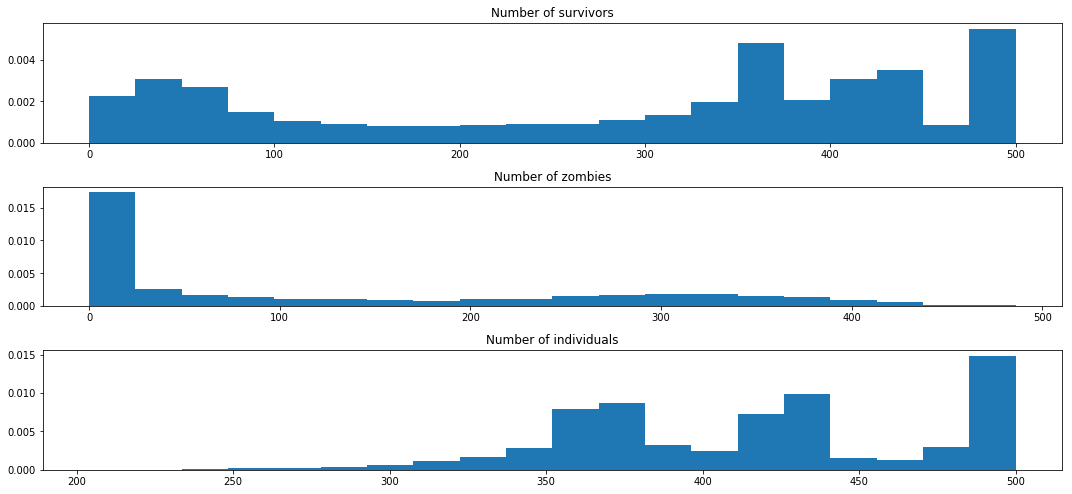

In [2]:
# Compute a new column (number of survivors)
data['survivors'] = data['s_num'] + data['r_num']

# Plot a a few distribution
nbins = 20
plt.figure(figsize=(15, 9))
# --- Susceptibles
plt.subplot(411)
plt.title('Number of survivors')
plt.hist(data.survivors, bins=nbins, density=True)
# --- Infected
plt.subplot(412)
plt.title('Number of zombies')
plt.hist(data.i_num, bins=nbins, density=True)
# --- Total
plt.subplot(413)
plt.title('Number of individuals')
plt.hist(data.num, bins=nbins, density=True)
plt.tight_layout()

And here's the same information, after we have computed the min/max of simulations done with the same input parameters:

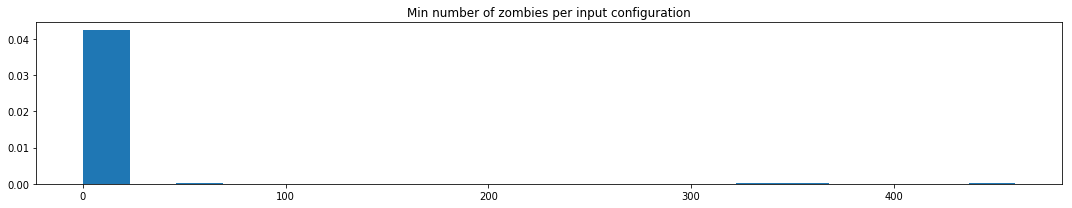

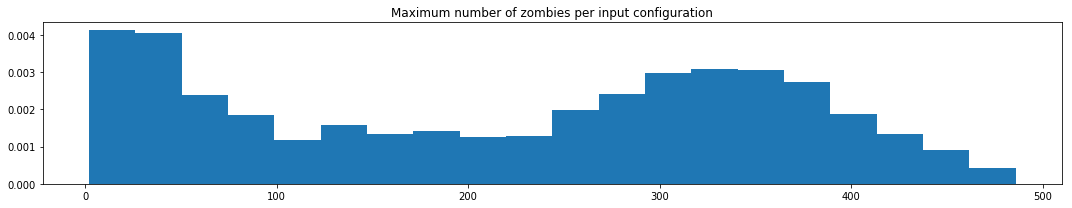

In [3]:
# Maximum number of zombies per scenario
gby = data.groupby(sim_in)
nbins = 20

plt.figure(figsize=(15, 3))
plt.title('Min number of zombies per input configuration')
plt.hist(gby['i_num'].min(), bins=nbins, density=True)
plt.tight_layout()

plt.figure(figsize=(15, 3))
plt.title('Maximum number of zombies per input configuration')
plt.hist(gby['i_num'].max(), bins=nbins, density=True)
plt.tight_layout()

There is considerable variability: in this situation, our network model has a hard time making an accurate prediction: when optimizing the weights for minimum MSE, there is large irreducible error.

One way to deal with this situation is to pre-aggregate the data, for example by taking the mean over groups of runs with the same values for the input parameters.

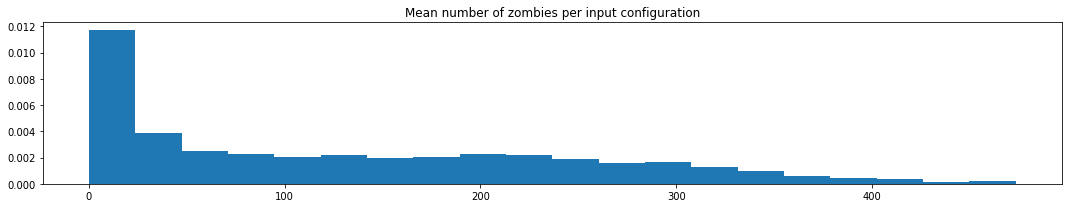

In [4]:
# Maximum number of zombies per scenario
gby = data.groupby(sim_in)
nbins = 20

plt.figure(figsize=(15, 3))
plt.title('Mean number of zombies per input configuration')
plt.hist(gby['i_num'].mean(), bins=nbins, density=True)
plt.tight_layout()

We can also repeat our analysis of the impact of each paramter from this perspective:

In [5]:
# Compute averages by input value
mdata = gby[['i_num', 'survivors']].mean().reset_index()
mdata.head()

,edge_ratio,inf_prob,act_rate,rec_rate,ds_rate,di_rate,i_num,survivors
0,0.001,0.3,1,0.0,0.000,0.03,4.100000,495.633333
1,0.001,0.3,1,0.0,0.000,0.13,1.800000,497.166667
2,0.001,0.3,1,0.0,0.000,0.23,1.133333,497.300000
3,0.001,0.3,1,0.0,0.025,0.03,3.900000,424.233333
4,0.001,0.3,1,0.0,0.025,0.13,1.966667,425.633333


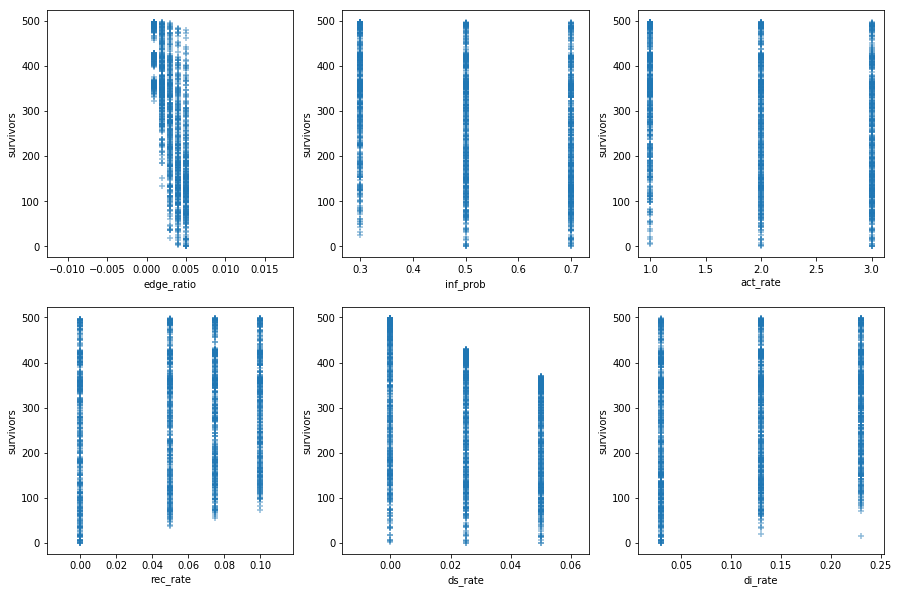

In [6]:
# Effect of the input parameters in the number of survivorss
nrows = int(np.ceil(n_in / 3))
plt.figure(figsize=(15, 5*nrows))
for i, in_name in enumerate(sim_in):
    plt.subplot(nrows, 3, i+1)
    plt.scatter(mdata[in_name], mdata['survivors'], marker='+', label='survivors', color='C0', alpha=0.5)
    plt.xlabel(in_name)
    plt.ylabel('survivors')

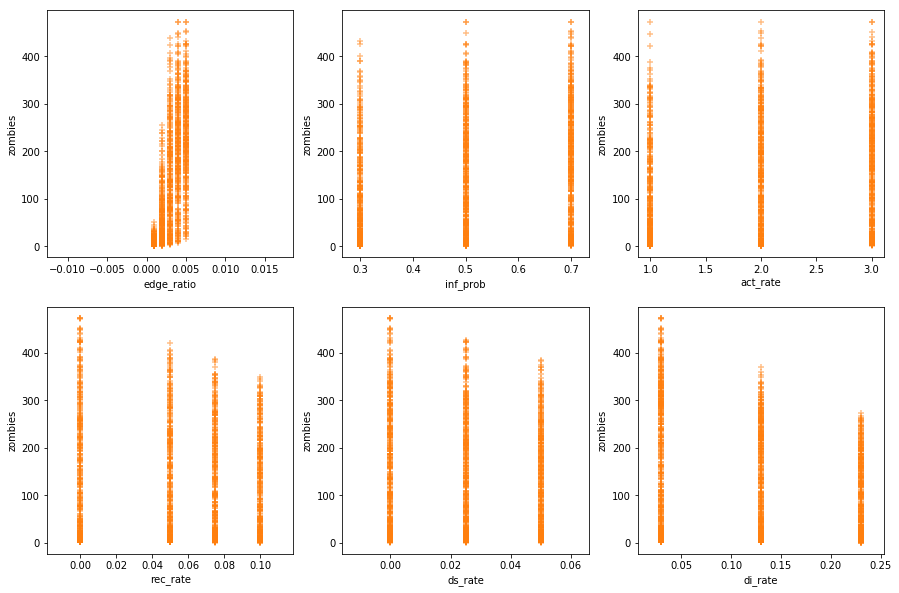

In [7]:
# Effect of the input parameters in the number of survivorss
nrows = int(np.ceil(n_in / 3))
plt.figure(figsize=(15, 5*nrows))
for i, in_name in enumerate(sim_in):
    plt.subplot(nrows, 3, i+1)
    plt.scatter(mdata[in_name], mdata['i_num'], marker='+', label='survivors', color='C1', alpha=0.5)
    plt.xlabel(in_name)
    plt.ylabel('zombies')

## 2) We have split the dataset at random

In ML tasks, it is common to obtain training, validation, and test data via random splitting. This is done because usually the dataset encodes some _desired_ bias on the probability distribution of the real data the we want to preserve.

However, the ML task that we are addressing is _very different_.

We will eventually embed our ML models into an optimization model, which will be explored by a solver looking for an optimal solution. In this setting, _it is very hard to know a priory which areas of the search space need to be better represented_.

One way to deal with this issue is to resort to active learning: for examples, see [our survey on integrating ML and optimization at the modeling level](). So far, active learning in the context of EML has not been investigated: this is an open research direction!

Another method to deal with the same issue consists in doing what we have in fact already done: using a factorial design for generating the dataset, so that all areas of the search space are decently represented in the dataset. 

If we take this approach, however, it makes sense to _respect the factorial design when splitting the dataset_.

Note that this is not really hurting our results right now (random splitting still results in dataset with similar distributions), but will end up haunting us later, at problem solving time, like an angry ghost or a particularly greasy dinner ;-) 

Let's do this split & aggregate thing!

In [8]:
# Aggregate + split into training, validation, and test data
data_tr = []
data_vl = []
data_ts = []
for lbl, gdata in data.groupby(sim_in):
    lnum = len(gdata)
    sep1 = int(lnum * 2/3)
    sep2 = int(lnum * 5/6)
    gdata_tr = gdata.iloc[:sep1]
    gdata_vl = gdata.iloc[sep1:sep2]
    gdata_ts = gdata.iloc[sep2:]
    data_tr.append(lbl + (gdata_tr['i_num'].mean(),) + (gdata_tr['survivors'].mean(),))
    data_vl.append(lbl + (gdata_vl['i_num'].mean(),) + (gdata_vl['survivors'].mean(),))
    data_ts.append(lbl + (gdata_ts['i_num'].mean(),) + (gdata_ts['survivors'].mean(),))
    
data_tr = pd.DataFrame(data=data_tr, columns=sim_in + sim_out)
data_vl = pd.DataFrame(data=data_vl, columns=sim_in + sim_out)
data_ts = pd.DataFrame(data=data_ts, columns=sim_in + sim_out)

Then we need to standardize:

In [9]:
# Standardize inputs
means_in = data_tr[sim_in].mean(axis=0)
stds_in = data_tr[sim_in].std(axis=0)
data_tr[sim_in] = (data_tr[sim_in] - means_in) / stds_in
data_vl[sim_in] = (data_vl[sim_in] - means_in) / stds_in
data_ts[sim_in] = (data_ts[sim_in] - means_in) / stds_in

# Standardize output
data_tr[sim_out] /= pop_size
data_vl[sim_out] /= pop_size
data_ts[sim_out] /= pop_size

And to store the new datasets:

In [10]:
# Store into an HDF5 archive
hdf_fname = os.path.join('shared', 'za_processed.h5')
with pd.HDFStore(hdf_fname, 'w') as store:
    store['data'] = data
    store['data_tr'] = data_tr
    store['data_vl'] = data_vl
    store['data_ts'] = data_ts
    store['means_in'] = means_in
    store['stds_in'] = stds_in
    store['sim_in'] = pd.Series(sim_in)
    store['sim_out'] = pd.Series(sim_out)
    store['in_defaults'] = pd.Series(index=sim_in, data=in_defaults)
    store['meta'] = pd.Series(index=['pop_size'], data=[pop_size])